In [8]:
#dataset is Mental Health Client-Level Data from SAMHSA
#https://www.datafiles.samhsa.gov/dataset/mental-health-client-level-data-2021-mh-cld-2021-ds0001

In [1]:
!ls

mhcld_puf_2021.csv
pca_mental-health_client-level.png
t-sne_mental_health_client-level_data.ipynb
tsne_plot_mental-health_client-level_data.png


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("mhcld_puf_2021.csv")

In [4]:
data.columns

Index(['YEAR', 'AGE', 'EDUC', 'ETHNIC', 'RACE', 'GENDER', 'SPHSERVICE',
       'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2',
       'MH3', 'SUB', 'MARSTAT', 'SMISED', 'SAP', 'EMPLOY', 'DETNLF', 'VETERAN',
       'LIVARAG', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG',
       'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG',
       'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG',
       'STATEFIP', 'DIVISION', 'REGION', 'CASEID'],
      dtype='object')

In [5]:
disorder_cols = ['TRAUSTREFLG','ANXIETYFLG','ADHDFLG','BIPOLARFLG','DEPRESSFLG','SCHIZOFLG','PERSONFLG']
data = data[disorder_cols]

In [6]:
#drop YEAR since all same
#drop CASEID since index column
#need to one-hot encode categorical data
#data = data.drop(columns=['YEAR','CASEID'])

In [7]:
data.head()

,TRAUSTREFLG,ANXIETYFLG,ADHDFLG,BIPOLARFLG,DEPRESSFLG,SCHIZOFLG,PERSONFLG
0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0
4,1,1,0,0,1,0,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6509025 entries, 0 to 6509024
Data columns (total 7 columns):
 #   Column       Dtype
---  ------       -----
 0   TRAUSTREFLG  int64
 1   ANXIETYFLG   int64
 2   ADHDFLG      int64
 3   BIPOLARFLG   int64
 4   DEPRESSFLG   int64
 5   SCHIZOFLG    int64
 6   PERSONFLG    int64
dtypes: int64(7)
memory usage: 347.6 MB


In [12]:
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
#perform PCA without CAS connection
from sklearn import datasets, decomposition
#fill missing values
#X = data.fillna(data.mean())
#drop missing values
X = data.dropna()
X = X[:10_000]
n_samples = X.shape[0]

In [13]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X.shape

(10000, 7)

In [14]:
#https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
# We center the data and compute the sample covariance matrix
X_centered = X - np.mean(X, axis=0)
cov_matrix = np.dot(X_centered.T, X_centered) / n_samples
eigenvalues = pca.explained_variance_
for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):    
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
    print(eigenvalue)

0.2697331489214231
0.269760124933918
0.18026927568040588
0.18028730441084798
0.15969005408546816
0.15970602468794282


In [15]:
#create pandas dataframes from label and pca transformed data
X_transform = pca.transform(X)
transform_df = pd.DataFrame(X_transform,columns=['score0','score1','score2'])

In [16]:
X_transform.shape

(10000, 3)

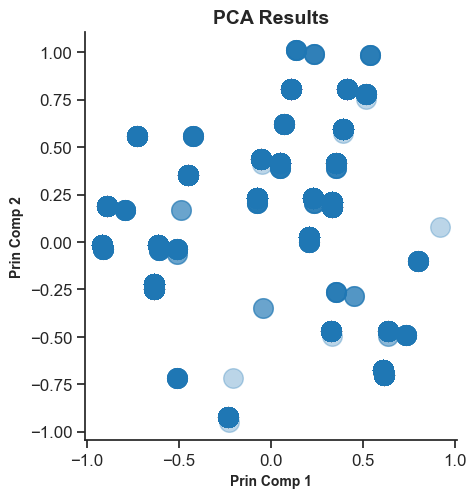

In [17]:
# Plot of PCA

# Set style of scatterplot
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

# Create scatterplot of dataframe
sns.lmplot(x='score0',
           y='score1',
           data=transform_df,
           fit_reg=False,
           legend=True,
           #size=9,
           #hue='score2',
           scatter_kws={"s":200, "alpha":0.3})

plt.title('PCA Results', weight='bold').set_fontsize('14')
plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')
plt.savefig('pca_mental-health_client-level.png')

In [18]:
from sklearn.manifold import TSNE

In [32]:
tsne = TSNE(n_components=2, verbose=1, perplexity=1000, n_iter=300)

In [33]:
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 3001 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 10.013s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.878254
[t-SNE] KL divergence after 300 iterations: 0.176442


In [34]:
tsne_df = pd.DataFrame(columns=['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]

In [35]:
tsne_df.shape

(10000, 2)

In [36]:
#NOTE: 
#t-SNE depends heavily on perplexity
#ensure no id column got mixed in
tsne_df.head(100)

,tsne-2d-one,tsne-2d-two
0,-5.928636,-1.270274
1,3.170667,-5.029696
2,3.992335,0.470709
3,3.170696,-5.029780
4,-1.963545,-1.520792
...,...,...
95,5.904195,2.935334
96,-4.946828,3.906589
97,-0.796365,-3.653974
98,3.991886,0.471430


/var/folders/4d/rp7dhwss6znf18sks0v304d80000gn/T/ipykernel_1622/1167394705.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.scatterplot(


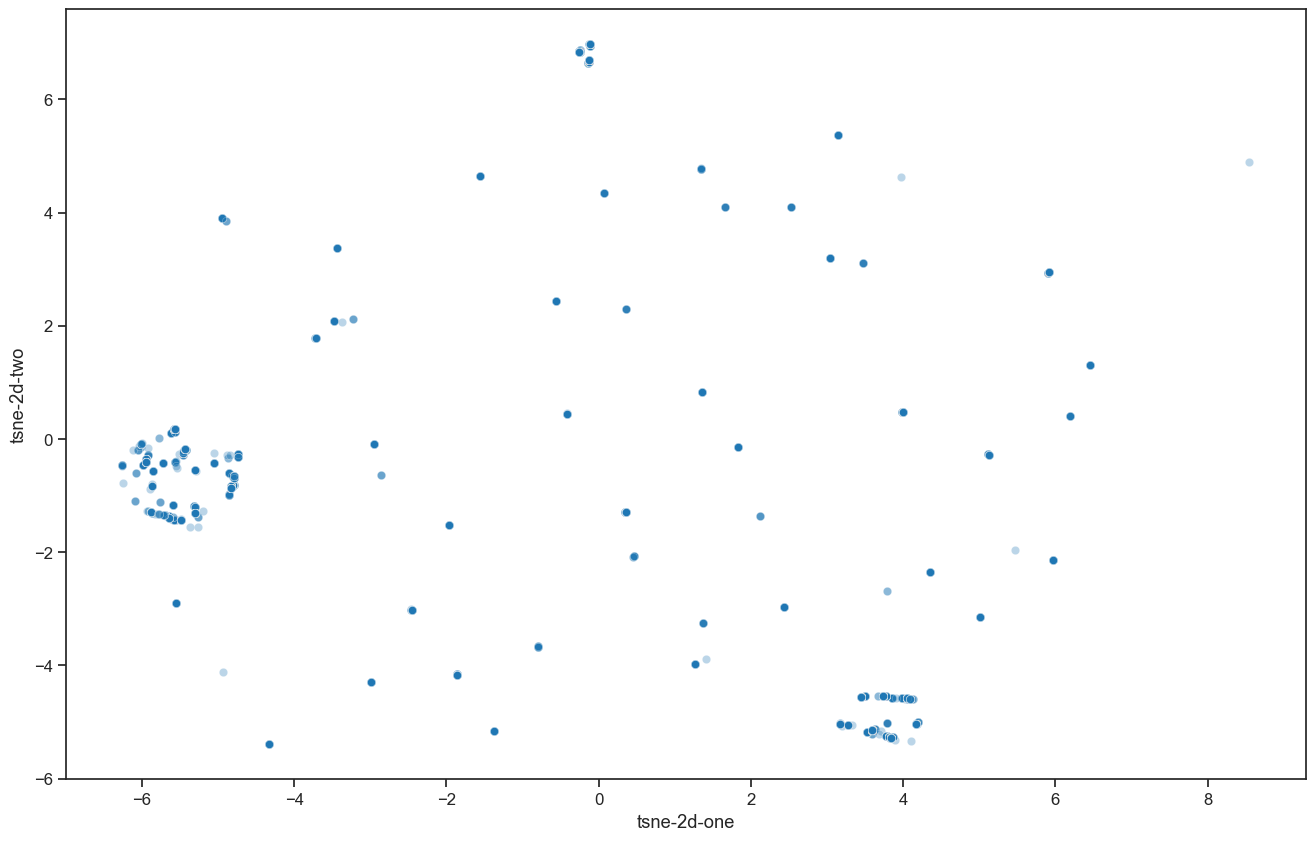

In [37]:
#plot the t-SNE results
plt.figure(figsize=(16,10))
plot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    #hue="y",
    palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

In [38]:
fig = plot.get_figure()
fig.savefig("tsne_plot_mental-health_client-level_data_perplexity=1000.png")